# Model

In [84]:
from custom_transformers import ModifiedBertForSequenceClassification
from transformers import AutoTokenizer
import torch

In [ ]:
model = ModifiedBertForSequenceClassification.from_pretrained(
    '/home/Models/TookaBERT-Base/',
    num_labels=163,
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained('/home/Models/TookaBERT-Base/', )

In [3]:
tokens = tokenizer(
    text=['سلام', 'خوبی؟', 'حالت چطوره؟'],
    return_tensors='pt',
    padding=True,
    truncation=True
).to(model.device)

In [4]:
labels = torch.randint(0, 2, (3,163), dtype=torch.float32)

In [15]:
outputs = model(**tokens, labels=labels.to(model.device))

In [18]:
outputs.keys()

odict_keys(['loss', 'logits'])

In [19]:
model.config.problem_type

'multi_label_classification'

# DataLoader

In [1]:
from custom_transformers import ModifiedBertForSequenceClassification
from custom_transformers.utils.data import SQLDataset
from custom_transformers.utils.loss import CombinedLoss, FocalLossWithWeight
from torch.utils.data import DataLoader
from transformers import get_scheduler
from torch.optim import AdamW
import torch
import os
from ast import literal_eval
from dotenv import load_dotenv
from collections import Counter
import matplotlib.pyplot as plt
from custom_transformers.utils.trainer import Trainer
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [2]:
load_dotenv()

model = ModifiedBertForSequenceClassification.from_pretrained(
    '/home/Models/TookaBERT-Base/',
    num_labels=163,
    device_map='auto',
)

for name, param in model.named_parameters():
    if name not in ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']:
        param.requires_grad = False

connection_params = {
    'dbname': os.getenv('DBNAME'),
    'user': os.getenv('USERNAME'),
    'password': os.getenv('PASS'),
    'host': os.getenv('HOST', 'localhost'),
    'port': os.getenv('PORT', '5432')
}
dataset = SQLDataset(
    pretrained_model_name_or_path='/home/Models/TookaBERT-Base/',
    connection_params=connection_params,
    num_classes=163
)

Some weights of ModifiedBertForSequenceClassification were not initialized from the model checkpoint at /home/Models/TookaBERT-Base/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
cursor = dataset.connection.cursor()

query = """
    SELECT labels2
    FROM dbo.activity 
    WHERE labels2 IS NOT NULL AND labels2 NOT LIKE '%[]%'
"""

cursor.execute(query)
labels = [literal_eval(row[0]) for i, row in enumerate(cursor.fetchall())]

# Flatten the list to count occurrences of each label
flat_labels = [label for sublist in labels for label in sublist]

# Count occurrences of each label
label_counts = Counter(flat_labels)

total_samples = sum(label_counts.values())

# Inverse of frequency for each class
class_weights = {label: total_samples / count for label, count in label_counts.items()}

# Normalize weights (optional but can help to stabilize training)
max_weight = max(class_weights.values())
class_weights = {label: weight / max_weight for label, weight in class_weights.items()}

num_classes = 163
class_weights_tensor = torch.zeros(num_classes, dtype=torch.float32)

for label, weight in class_weights.items():
    class_weights_tensor[label] = weight
class_weights_tensor = class_weights_tensor.to(model.device)

# Apply log transformation and scaling
log_scaled_weights = torch.log(class_weights_tensor + 1e-10)  # Avoid log(0)
log_scaled_weights = (log_scaled_weights - log_scaled_weights.min()) / (log_scaled_weights.max() - log_scaled_weights.min())

# Scale class weights from [0, 1] to [0.2, 1]
scaled_class_weights = 0.8 * log_scaled_weights + 0.2

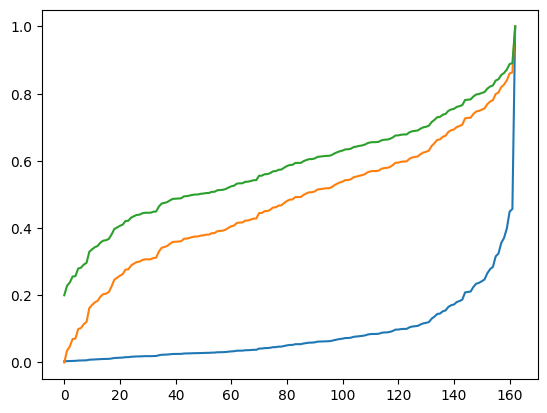

In [5]:
plt.plot(sorted(class_weights_tensor.cpu()))
plt.plot(sorted(log_scaled_weights.cpu()))
plt.plot(sorted(scaled_class_weights.cpu()))
plt.show()

In [6]:
train_indices, test_indices = train_test_split(
    list(dataset.id_map.keys()),
    test_size=0.1,
)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, 512, shuffle=True, collate_fn=dataset.collate_fn, num_workers=1)
test_loader = DataLoader(test_dataset, 512, shuffle=True, collate_fn=dataset.collate_fn, num_workers=1)

optimizer = AdamW(model.parameters(), lr=5e-5)
# loss_fn = CombinedLoss(gamma=2, alpha=0.043, class_weights=class_weights_tensor, focal_weight=1 - 1/163, bce_weight=1/163)
loss_fn = FocalLossWithWeight(gamma=2, alpha=0.043, class_weights=scaled_class_weights)

num_epochs = 10
num_training_steps = len(train_loader) * num_epochs 
warmup_steps = int(0.1 * num_training_steps)

scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)

trainer = Trainer(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    test_loader
)

In [7]:
trainer.fit(num_epochs)

Epoch   1/10


Training Loss: 0.0036
Validation Loss: 0.0007

Epoch   2/10


Training Loss: 0.0006
Validation Loss: 0.0006

Epoch   3/10


Training Loss: 0.0006
Validation Loss: 0.0006

Epoch   4/10


Training Loss: 0.0006
Validation Loss: 0.0006

Epoch   5/10


Training Loss: 0.0006
Validation Loss: 0.0006

Epoch   6/10


Training Loss: 0.0006
Validation Loss: 0.0006

Epoch   7/10


Training Loss: 0.0006
Validation Loss: 0.0005

Epoch   8/10


Training Loss: 0.0006
Validation Loss: 0.0005

Epoch   9/10


Training Loss: 0.0006
Validation Loss: 0.0005

Epoch  10/10


Training Loss: 0.0005
Validation Loss: 0.0005



In [1]:
# # Training loop
# learning_rates = []
# running_loss = []

# for epoch in range(num_epochs):
#     progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=True)
    
#     for batch in progress_bar:
#         batch = batch.to(model.device)
        
#         input_ids, attention_mask, label = batch.values()
#         # Forward pass
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)

#         logits = outputs['logits']
#         loss = loss_fn(logits, label)

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         scheduler.step()  # Update the learning rate after each step

#         # Track the loss
#         running_loss.append(loss.item())
        
#         # Track the learning rate
#         lr = optimizer.param_groups[0]['lr']
#         learning_rates.append(lr)
        
#         # Update progress bar with both loss and learning rate
#         progress_bar.set_postfix(loss=running_loss[-1], next_lr=lr)
    

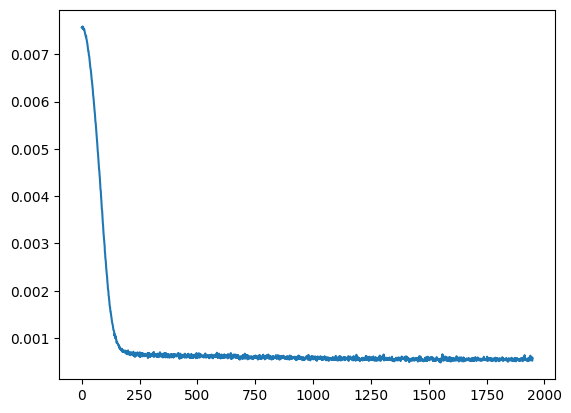

In [14]:
plt.plot([loss for losses in trainer.losses for loss in losses])

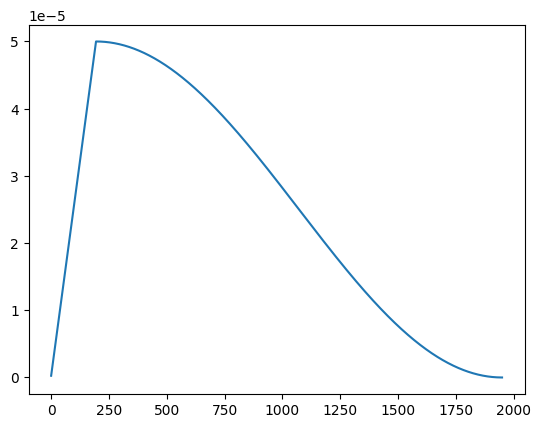

In [15]:
plt.plot(trainer.learning_rates)


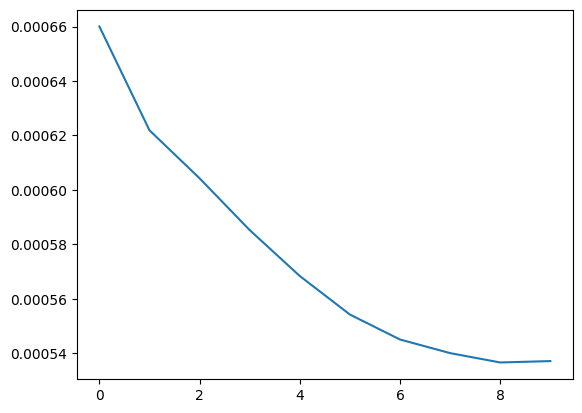

In [16]:
plt.plot(trainer.validation_loss)

In [17]:
tokens = dataset.tokenizer(
    'ارایه کلیه خدمات مهندسی کشاورزی شامل مشاوره اجرا نظارت بر اجرای انواع طرحهای ابیاری قطره ای بارانی تحت فشار و برقی کردن چاه های کشاورزی جهت بهبود عملیات زراعی در مزارع کشاورزی و باغات و تسطیح و اماده سازی و ابخیزداری و زهکشی کلیه زمینهای کشاورزی باغداری ایجاد فضای سبز گلخانه های فضای ازاد تهیه تولید تکثیر و پرورش گلهای اپارتمانی و انواع نهال تهیه تولید خرید فروش بسته بندی واردات صادرات انواع کودهای شیمیایی انواع بذر و نشا و کمپوست و سموم نباتی و ماشین الات کشاورزی و دامپروری ارایه خدمات مشاوره در زمینه بهبود عملیات زراعی و باغداری شناسایی و ردیابی افات زراعی و از بین بردن این افات بصورت علمی شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه امور بازرگانی شامل واردات صادرات ترخیص حق العمل کاری کلیه کالاهای مجاز از کلیه گمرکات و بنادر کشور و شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه عملیات اجرایی انواع طرحهای مخابراتی تاسیساتی ساختمانی راهسازی و گاز رسانی ابرسانی شهری و روستایی صنعتی شامل حفاری کابل کشی لوله گذاری کانال سازی خاکبرداری و جدول کشی انجام کلیه امور پروژه های ساختمانی مسکونی اسفالت کاری اسکلت سازی و محوطه سازی و تخریب و خاکبرداری خاکریزی و پی کنی دیوار چینی کلیه امور نقشه کشی (Gps – GPRS) کلیه امور اسنادی (خدمات اسنادی قبض انبار منطقه ویژه اصلاحیه مانیفست صورتحساب مجوز خروج کالا (بیجک) تسویه و صورت مجالس شناور صورت وضعیت خروج شناور)',
    truncation=True,
    padding=True,
    return_tensors='pt'
)

In [29]:
with torch.no_grad():
    output = trainer.model(**tokens.to('cuda'))

In [30]:
torch.sigmoid(output['logits'][0])

tensor([0.1468, 0.1537, 0.1592, 0.1800, 0.1343, 0.1318, 0.1135, 0.1297, 0.1697,
        0.1735, 0.1109, 0.1152, 0.2097, 0.1117, 0.1023, 0.1193, 0.1666, 0.1275,
        0.1203, 0.1283, 0.1206, 0.1579, 0.1267, 0.0985, 0.1507, 0.2246, 0.2371,
        0.1637, 0.1854, 0.2188, 0.2083, 0.1751, 0.1588, 0.1766, 0.0881, 0.2208,
        0.1694, 0.2099, 0.1505, 0.1456, 0.2115, 0.1394, 0.1092, 0.1110, 0.1220,
        0.1259, 0.1298, 0.1030, 0.1588, 0.2077, 0.1550, 0.1417, 0.1195, 0.1286,
        0.1017, 0.1330, 0.1024, 0.1761, 0.1334, 0.0909, 0.1014, 0.0793, 0.0908,
        0.1354, 0.0978, 0.1186, 0.1325, 0.1434, 0.1297, 0.1340, 0.1221, 0.1160,
        0.0958, 0.1601, 0.1274, 0.1086, 0.1289, 0.0990, 0.1117, 0.1334, 0.1401,
        0.1211, 0.0976, 0.1376, 0.0908, 0.1553, 0.1243, 0.0791, 0.0912, 0.1064,
        0.1561, 0.1220, 0.1403, 0.1454, 0.1491, 0.1041, 0.1593, 0.1026, 0.1328,
        0.1260, 0.1653, 0.1372, 0.1860, 0.1320, 0.1672, 0.1180, 0.1078, 0.1074,
        0.0956, 0.1348, 0.1564, 0.1092, 

In [25]:
torch.argwhere(torch.sigmoid(output['logits'][0]) > 0.22).cpu().view(-1)

tensor([25, 26, 35])

In [33]:
dataset.tokenizer.save_pretrained('./saved_models/myBERT-Base2/')
trainer.model.save_pretrained('./saved_models/myBERT-Base2/')